# **DATA LOAD AND LOCAL STORING**

In [ ]:
import os
import tensorflow as tf

LOAD KAGGLE DATASETS VIA API

In [ ]:
!pip install -q Kaggle
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! mkdir ~/.kaggle
! cp /content/gdrive/MyDrive/KaggleDatasetsAPI/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

DOWNLOAD DATASETS

In [ ]:
! kaggle datasets download -d rafyardhani/pneumonia-xray-update
#! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 1.83G/1.83G [00:41<00:00, 100MB/s]
100% 1.83G/1.83G [00:41<00:00, 46.9MB/s]


In [ ]:
! unzip pneumonia-xray-update.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0491-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0493-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0496-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0497-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0499-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0500-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0501-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0502-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0503-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0506-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0507-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0508-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0509-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0511-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NO

the datasets are stored locally on **chest_xray** 

*spesifically* on /content/chest_xray

In [ ]:
TRAINING_DIR = "/content/chest_xray/train"
TESTING_DIR = "/content/chest_xray/test"
VALIDATION_DIR = "/content/chest_xray/val"

TRAINING_PNEUMONIA_DIR = "/content/chest_xray/train/PNEUMONIA"
TRAINING_NORMAL_DIR = "/content/chest_xray/train/NORMAL"

TESTING_PNEUMONIA_DIR = "/content/chest_xray/test/PNEUMONIA"
TESTING_NORMAL_DIR = "/content/chest_xray/test/NORMAL"

VALIDATION_PNEUMONIA_DIR = "/content/chest_xray/val/PNEUMONIA"
VALIDATION_NORMAL_DIR = "/content/chest_xray/val/NORMAL"

print(f"\n\nThere are {len(os.listdir(TRAINING_PNEUMONIA_DIR))} images of Pneumonia for training")
print(f"There are {len(os.listdir(TRAINING_NORMAL_DIR))} images of Normal for training")
print(f"There are {len(os.listdir(TESTING_PNEUMONIA_DIR))} images of Pneumonia for testing")
print(f"There are {len(os.listdir(TESTING_NORMAL_DIR))} images of Normal for testing")
print(f"There are {len(os.listdir(VALIDATION_PNEUMONIA_DIR))} images of Pneumonia for Validating")
print(f"There are {len(os.listdir(VALIDATION_NORMAL_DIR))} images of Normal for Validating")



There are 3875 images of Pneumonia for training
There are 2341 images of Normal for training
There are 690 images of Pneumonia for testing
There are 534 images of Normal for testing
There are 233 images of Pneumonia for Validating
There are 233 images of Normal for Validating


# CREATE MODEL

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

def create_model():
 
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=1e-4),
                metrics=['accuracy'])
  
  return model

# **DATA AUGMENTATION**



DATA AUGMENTATION / PREPROCESSING

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    vertical_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR, 
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        shuffle=True)

# Flow validation images in batches of 20 using test_datagen generator
test_generator = test_datagen.flow_from_directory(
        TESTING_DIR,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        shuffle=True)

# Flow validation images in batches of 20 using valid_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        shuffle=True)

Found 6216 images belonging to 2 classes.
Found 1224 images belonging to 2 classes.
Found 466 images belonging to 2 classes.


# TRANSFER LEARNING

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-05-31 13:14:49--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 142.250.188.48, 172.217.1.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   165MB/s    in 0.5s    

2022-05-31 13:14:50 (165 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
def create_pre_trained_model(local_weights_file):
  ### START CODE HERE
  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = None) 

  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
    layer.trainable = False

  ### END CODE HERE

  return pre_trained_model

In [ ]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


CREATE CALLBACK FOR TRESHOLD ACC

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('val_accuracy')>=0.95) and (logs.get('accuracy')>=0.97)):
      print("\nReached 95% acc and 95% validation acc so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
def output_of_last_layer(pre_trained_model):
  ### START CODE HERE
  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)
  ### END CODE HERE

  return last_output

In [ ]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [ ]:
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
# GRADED FUNCTION: create_final_model
def create_final_model(pre_trained_model, last_output):
  # Flatten the output layer to 1 dimension
  x = tf.keras.layers.Flatten()(last_output)

  ### START CODE HERE

  # Add a fully connected layer with 1,024 hidden units and ReLU activation
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  # Add a dropout rate of 0.2
  x = tf.keras.layers.Dropout(0.2)(x)                  
  # Add a final sigmoid layer for classification
  x = tf.keras.layers.Dense (1, activation='sigmoid')(x)      

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)
  # Compile the model
  model.compile(optimizer = RMSprop(learning_rate=1e-4), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

  ### END CODE HERE
  
  return model

In [ ]:
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.


# TRAIN MODEL

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = test_generator,
                    epochs = 20,
                    verbose = 2,
                    callbacks=[checkpoint, lr_reduce])

Epoch 1/20
195/195 - 126s - loss: 0.3439 - accuracy: 0.8655 - val_loss: 0.1991 - val_accuracy: 0.9322 - lr: 1.0000e-04 - 126s/epoch - 649ms/step
Epoch 2/20
195/195 - 102s - loss: 0.2031 - accuracy: 0.9255 - val_loss: 0.3459 - val_accuracy: 0.8889 - lr: 1.0000e-04 - 102s/epoch - 524ms/step
Epoch 3/20
195/195 - 103s - loss: 0.1752 - accuracy: 0.9350 - val_loss: 0.1939 - val_accuracy: 0.9461 - lr: 1.0000e-04 - 103s/epoch - 529ms/step
Epoch 4/20

Epoch 4: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
195/195 - 103s - loss: 0.1597 - accuracy: 0.9448 - val_loss: 0.1900 - val_accuracy: 0.9469 - lr: 1.0000e-04 - 103s/epoch - 529ms/step
Epoch 5/20
195/195 - 102s - loss: 0.1156 - accuracy: 0.9577 - val_loss: 0.1990 - val_accuracy: 0.9477 - lr: 3.0000e-05 - 102s/epoch - 521ms/step
Epoch 6/20

Epoch 6: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
195/195 - 102s - loss: 0.1170 - accuracy: 0.9554 - val_loss: 0.1533 - val_accuracy: 0.9485 - lr: 3.0000e-05 -

**ini default kalau gapake transfer learning**

In [ ]:
'''
# Constant for epochs
EPOCHS = 28

# Create a new model
model = create_model()

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=50,  # 2000 images = batch_size * steps
      epochs=EPOCHS,
      validation_data=test_generator,
      validation_steps=20,  # 1000 images = batch_size * steps
      verbose=1,
      callbacks=[callbacks])
      '''

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()



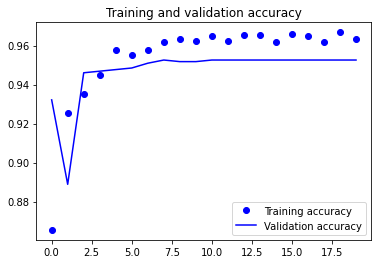

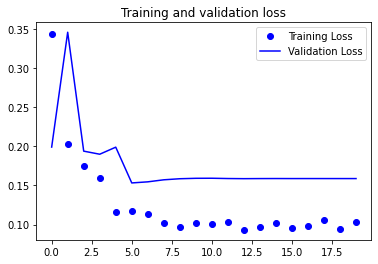

In [ ]:
plot_loss_acc(history)

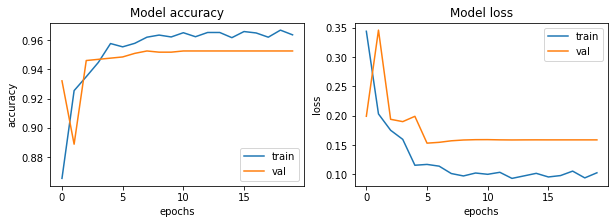

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# EVALUATE MODEL

In [ ]:
model.evaluate(test_generator)

39/39 [==============================] - 12s 299ms/step - loss: 0.1588 - accuracy: 0.9526


[0.15884080529212952, 0.9526143670082092]

# EXPORT MODEL

In [ ]:
PNEUX_SAVED_MODEL = "pneux_saved_model"

tf.saved_model.save(model, PNEUX_SAVED_MODEL)

INFO:tensorflow:Assets written to: pneux_saved_model/assets


In [ ]:
%%bash -s $PNEUX_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['input_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 150, 150, 3)
      name: serving_default_input_1:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [ ]:
loaded = tf.saved_model.load(PNEUX_SAVED_MODEL)

In [ ]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'input_1': TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_1')})
{'dense_1': TensorSpec(shape=(None, 1), dtype=tf.float32, name='dense_1')}


# CONVERT TO TFLITE

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(PNEUX_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

# Convert to H5

In [ ]:
saved_model_path = "./my_model.h5"


model.save(saved_model_path)
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

# DOWNLOAD TFLITE AND LABELS

In [ ]:
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)
    
class_names = ['Pneumonia', 'Normal']

with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

    

SAVE TO DRIVE FOR DOWNLOAD PURPOSE

In [ ]:
from google.colab import drive
drive.mount('drive')

!cp labels.txt "/content/drive/MyDrive/"
!cp converted_model.tflite "/content/drive/MyDrive"

Mounted at drive
